<a href="https://colab.research.google.com/github/ripper763/CS29006_SW_Lab_Spr2023/blob/main/Myntra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import lightgbm as lgb
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [ ]:
df = pd.read_csv('Dataset myntra - summer-products (1).csv')

In [ ]:
# Feature Engineering
def engineer_features(df):
    # Convert price to numeric, assuming it's in string format
    df['price'] = pd.to_numeric(df['price'], errors='coerce')

    # Calculate price difference from retail price
    df['price_diff'] = df['retail_price'] - df['price']

    # Extract number of tags
    df['tag_count'] = df['tags'].str.count(',') + 1

    # Calculate total ratings
    df['total_ratings'] = (df['rating_five_count'] + df['rating_four_count'] +
                           df['rating_three_count'] + df['rating_two_count'] +
                           df['rating_one_count'])

    # Calculate rating ratio
    df['rating_ratio'] = (df['rating_five_count'] + df['rating_four_count']) / df['total_ratings']

    # Create 'is_trend' column (example threshold: items sold > 75th percentile)
    df['is_trend'] = (df['units_sold'] > df['units_sold'].quantile(0.75)).astype(int)

    return df


In [ ]:
 #Prepare features and target
df = engineer_features(df)

# Select features for the model
numeric_features = ['price', 'price_diff', 'rating', 'rating_count', 'tag_count', 'rating_ratio', 'inventory_total']
categorical_features = ['product_color', 'theme', 'crawl_month']

# Combine all features
features = numeric_features + categorical_features

X = df[features]
y = df['is_trend']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
X.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

<ipython-input-12-bd600549b45e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


In [ ]:
X_nans = X.isna().sum().reset_index()
X_nans[X_nans[0]!=0]

X_test_nans = X_test.isna().sum().reset_index()
X_test_nans[X_test_nans[0]!=0]

,index,0


In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Create a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Fit the model
pipeline.fit(X_train, y_train)

ValueError: Input X contains NaN.
RandomForestClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
# Create preprocessor with imputation
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Fit the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['price', 'price_diff',
                                                   'rating', 'rating_count',
                                                   'tag_count', 'rating_ratio',
                                                   'inventory_total']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['product_color', 'theme',
                                                   'crawl_month'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [ ]:
# Make predictions
y_pred = pipeline.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.95      0.97      0.96       260
           1       0.84      0.75      0.79        55

    accuracy                           0.93       315
   macro avg       0.89      0.86      0.87       315
weighted avg       0.93      0.93      0.93       315



In [ ]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,

In [ ]:
import numpy as np

def get_feature_names(column_transformer):
    feature_names = []
    for name, pipe, features in column_transformer.transformers_:
        if name != 'remainder':
            if isinstance(pipe, Pipeline):
                if isinstance(pipe.steps[-1][1], OneHotEncoder):
                    # Use get_feature_names_out() instead of get_feature_names()
                    feature_names.extend(pipe.steps[-1][1].get_feature_names_out(features).tolist())
                else:
                    feature_names.extend(features)
            elif isinstance(pipe, OneHotEncoder):
                # Use get_feature_names_out() instead of get_feature_names()
                feature_names.extend(pipe.get_feature_names_out(features).tolist())
            else:
                feature_names.extend(features)
    return feature_names

# Get feature names
feature_names = get_feature_names(pipeline.named_steps['preprocessor'])

# Get feature importances
feature_importance = pipeline.named_steps['classifier'].feature_importances_

# Create a dataframe of feature importances
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

print("\nTop 10 Important Features:")
print(feature_importance_df.head(10))


Top 10 Important Features:
                 feature  importance
3           rating_count    0.661098
2                 rating    0.066588
5           rating_ratio    0.062996
0                  price    0.041505
4              tag_count    0.041343
1             price_diff    0.040416
80  product_color_purple    0.006345
91   product_color_white    0.005095
18   product_color_black    0.004596
74    product_color_pink    0.003769


In [ ]:
#Function to predict trend probability for new items
def predict_trend_probability(new_items):
    return pipeline.predict_proba(new_items)[:, 1]

# Example usage:
new_items = X_test.head(10)  # Just using first 5 items from test set as an example
probabilities = predict_trend_probability(new_items)
print("\nTrend Probabilities for New Items:")
print(probabilities)


Trend Probabilities for New Items:
[0.   0.49 0.   0.06 0.04 0.03 0.04 0.   0.11 0.03]


In [ ]:
# Fit the model
pipeline.fit(X_train, y_train)

# Function to predict trend probability
def predict_trend_probability(items):
    return pipeline.predict_proba(items)[:, 1]

# Predict on test set
y_pred = pipeline.predict(X_test)
y_pred_proba = predict_trend_probability(X_test)

# Create a copy of X_test to add our predictions
results = X_test.copy()

In [ ]:
# Add columns for true labels, predicted labels, and probability
results['true_label'] = y_test
results['predicted_label'] = y_pred
results['trend_probability'] = y_pred_proba

# Categorize as trending or anti-trending
# Let's say items with >70% probability are trending, <30% are anti-trending
def categorize_trend(probability):
    if probability > 0.8:
        return 'Top Trending'
    elif probability > 0.65 and probability < 0.8:
        return 'Trending'
    elif probability < 0.15:
        return 'Top Anti-trending'
    elif probability < 0.3 and probability >0.15:
        return 'Anti-trending'
    else:
        return 'Neutral'

results['trend_category'] = results['trend_probability'].apply(categorize_trend)


In [ ]:
# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       260
           1       0.84      0.75      0.79        55

    accuracy                           0.93       315
   macro avg       0.89      0.86      0.87       315
weighted avg       0.93      0.93      0.93       315



In [ ]:
# Print summary of results
print("\nSummary of Results:")
print(results['trend_category'].value_counts())


Summary of Results:
trend_category
Top Anti-trending    242
Top Trending          31
Neutral               21
Anti-trending         11
Trending              10
Name: count, dtype: int64


In [ ]:
# Print top 10 trending items
print("\nTop 10 Trending Items:")
top_trending = results[results['trend_category'] == 'Trending'].sort_values('trend_probability', ascending=False)
print(top_trending[['trend_probability', 'trend_category'] + list(X_test.columns)].head(10))



Top 10 Trending Items:
      trend_probability trend_category  price  price_diff  rating  \
339                0.79       Trending   8.00       17.00    3.65   
350                0.79       Trending  14.00       -2.00    3.75   
433                0.78       Trending   2.00        1.00    4.09   
1463               0.76       Trending   6.00       11.00    4.24   
500                0.75       Trending   8.00       -1.00    3.39   
1503               0.74       Trending  14.00       -2.00    3.94   
297                0.73       Trending   3.00        0.00    4.12   
1106               0.69       Trending   2.00       24.00    4.36   
1168               0.68       Trending   5.67       13.33    3.53   
1384               0.66       Trending   6.00        4.00    4.06   

      rating_count  tag_count  rating_ratio  inventory_total product_color  \
339           2324         18      0.606713               50        yellow   
350           1892         18      0.640063               50

In [ ]:
# Print top 10 anti-trending items
print("\nTop 10 Anti-trending Items:")
top_anti_trending = results[results['trend_category'] == 'Anti-trending'].sort_values('trend_probability')
print(top_anti_trending[['trend_probability', 'trend_category'] + list(X_test.columns)].head(10))



Top 10 Anti-trending Items:
      trend_probability trend_category  price  price_diff  rating  \
175                0.16  Anti-trending  11.00       73.00    3.98   
1299               0.17  Anti-trending  12.00       90.00    4.11   
185                0.17  Anti-trending   5.65       -0.65    4.06   
1438               0.17  Anti-trending   8.00       -1.00    3.66   
1349               0.18  Anti-trending   8.00      244.00    3.88   
767                0.19  Anti-trending  22.00       -3.00    3.66   
1388               0.19  Anti-trending   9.00        8.00    4.18   
610                0.19  Anti-trending   4.74       15.26    4.05   
124                0.20  Anti-trending  12.00       31.00    3.59   
669                0.21  Anti-trending  11.00       -1.00    4.25   

      rating_count  tag_count  rating_ratio  inventory_total product_color  \
175            792         17      0.708333               50   pink & grey   
1299            75         11      0.773333            

In [ ]:
# Optional: Save results to CSV
results.to_csv('trend_prediction_results1.csv', index=False)
print("\nResults saved to 'trend_prediction_results.csv'")


Results saved to 'trend_prediction_results.csv'


In [ ]:
# Calculate and print accuracy
accuracy = (results['true_label'] == results['predicted_label']).mean()
print(f"\nModel Accuracy: {accuracy:.2f}")



Model Accuracy: 0.93


In [ ]:
# Print confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(results['true_label'], results['predicted_label'])
print("\nConfusion Matrix:")
print(cm)


Confusion Matrix:
[[252   8]
 [ 14  41]]


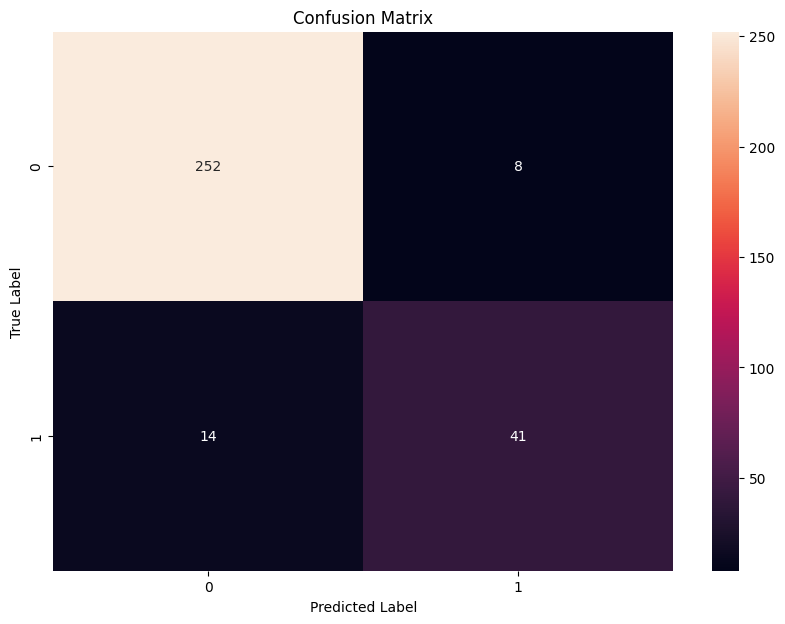

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


Top 10 Most Important Features:
                 feature  importance
3           rating_count    0.661098
2                 rating    0.066588
5           rating_ratio    0.062996
0                  price    0.041505
4              tag_count    0.041343
1             price_diff    0.040416
80  product_color_purple    0.006345
91   product_color_white    0.005095
18   product_color_black    0.004596
74    product_color_pink    0.003769


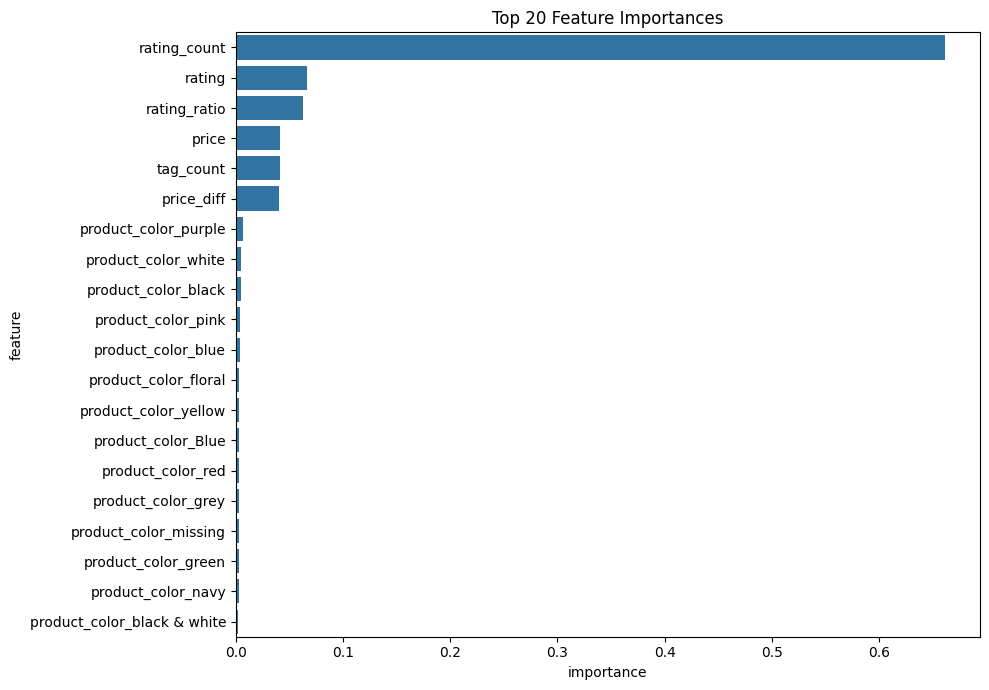

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Importance
def get_feature_names(column_transformer):
    feature_names = []
    for name, pipe, features in column_transformer.transformers_:
        if name != 'remainder':
            if isinstance(pipe, Pipeline):
                if isinstance(pipe.steps[-1][1], OneHotEncoder):
                    feature_names.extend(pipe.steps[-1][1].get_feature_names_out(features).tolist())
                else:
                    feature_names.extend(features)
            elif isinstance(pipe, OneHotEncoder):
                feature_names.extend(pipe.get_feature_names_out(features).tolist())
            else:
                feature_names.extend(features)
    return feature_names

feature_names = get_feature_names(pipeline.named_steps['preprocessor'])

feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': pipeline.named_steps['classifier'].feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

# Optional: Visualize feature importance
plt.figure(figsize=(10,7))
sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
plt.title('Top 20 Feature Importances')
plt.tight_layout()
plt.show()

In [ ]:
def get_recommendations(user_preferences, uniqueness_level):
    # Assume we have our trained pipeline and results DataFrame from before

    # Filter results based on user preferences (e.g., color, style, etc.)
    filtered_results = results[results.apply(lambda row: all(pref in row.values for pref in user_preferences), axis=1)]

    # Adjust recommendations based on uniqueness level
    if uniqueness_level < 0.3:  # More trendy
        recommendations = filtered_results[filtered_results['trend_category'] == 'Trending']
    elif uniqueness_level > 0.7:  # More unique
        recommendations = filtered_results[filtered_results['trend_category'] == 'Anti-trending']
    else:  # Balanced
        recommendations = filtered_results
    # recommendations['category'] = ['top', 'bottom', 'accessory', 'top', 'bottom'] # Example categories

    return recommendations.sort_values('trend_probability', ascending=(uniqueness_level > 0.5))

# Example usage
user_prefs = ['summer', 'casual']
uniqueness = 0.1  # User wants very unique outfits
recommendations = get_recommendations(user_prefs, uniqueness)
print(recommendations.head())

Empty DataFrame
Columns: [price, price_diff, rating, rating_count, tag_count, rating_ratio, inventory_total, product_color, theme, crawl_month, true_label, predicted_label, trend_probability, trend_category]
Index: []


In [ ]:
def get_recommendations(user_preferences, uniqueness_level, results):
    print(f"Initial results shape: {results.shape}")

    # Filter results based on user preferences (e.g., color, style, etc.)
    filtered_results = results[results.apply(lambda row: any(pref.lower() in str(row.values).lower() for pref in user_preferences), axis=1)]
    print(f"After preference filtering: {filtered_results.shape}")

    # Adjust recommendations based on uniqueness level
    if uniqueness_level < 0.3:  # More trendy
        recommendations = filtered_results[filtered_results['trend_category'].isin(['Trending', 'Top Trending'])]
    elif uniqueness_level > 0.7:  # More unique
        recommendations = filtered_results[filtered_results['trend_category'].isin(['Anti-trending', 'Top Anti-trending'])]
    else:  # Balanced
        recommendations = filtered_results

    print(f"After trend filtering: {recommendations.shape}")

    if recommendations.empty:
        print("No recommendations found. Returning all filtered results.")
        recommendations = filtered_results

    return recommendations.sort_values('trend_probability', ascending=(uniqueness_level > 0.5))

# Example usage
user_prefs = ['summer', 'casual']
uniqueness = 0.1  # User wants very trendy outfits

try:
    recommendations = get_recommendations(user_prefs, uniqueness, results)
    if not recommendations.empty:
        print("\nTop 5 Recommendations:")
        print(recommendations[['trend_probability', 'trend_category'] + list(results.columns)].head())
    else:
        print("No recommendations found.")
except Exception as e:
    print(f"An error occurred: {str(e)}")

# Debugging: Check for the presence of user preferences in the data
for pref in user_prefs:
    print(f"'{pref}' found in data: {any(results.apply(lambda row: pref.lower() in str(row.values).lower(), axis=1))}")

Initial results shape: (315, 14)
After preference filtering: (315, 14)
After trend filtering: (41, 14)

Top 5 Recommendations:
      trend_probability trend_category  price  price_diff  rating  \
811                0.98   Top Trending   8.00       -1.00    3.82   
1208               0.97   Top Trending   3.92        0.08    3.76   
1237               0.96   Top Trending   8.00       -1.00    3.63   
1007               0.95   Top Trending   8.00       -1.00    4.14   
654                0.95   Top Trending  11.00        3.00    3.76   

      rating_count  tag_count  rating_ratio  inventory_total product_color  \
811           2520         13      0.655952               50        orange   
1208          4367         14      0.633845               50         black   
1237          2058         14      0.593294               50         black   
1007          2737         21      0.769456               50          Pink   
654           8029         14      0.646531               50        

In [ ]:
def display_style_comparison(item):
    trending_items = results[results['trend_category'] == 'Trending']
    anti_trending_items = results[results['trend_category'] == 'Anti-trending']

    # Find similar trendy and anti-trendy items
    similar_trendy = find_similar_items(item, trending_items)
    similar_anti_trendy = find_similar_items(item, anti_trending_items)

    print("Popular style:")
    print(similar_trendy.iloc[0])
    print("\nUnique twist:")
    print(similar_anti_trendy.iloc[0])

def find_similar_items(item, item_pool):
    # Implement similarity measure (e.g., based on features)
    # This is a simplified version
    return item_pool.iloc[(item_pool[numeric_features] - item[numeric_features]).abs().sum(axis=1).argsort()]

# Example usage
selected_item = results.iloc[0]  # Just an example
display_style_comparison(selected_item)

Popular style:
price                     6.0
price_diff                4.0
rating                   4.06
rating_count             1496
tag_count                  28
rating_ratio         0.725267
inventory_total            50
product_color           black
theme                  summer
crawl_month           2020-08
true_label                  1
predicted_label             1
trend_probability        0.66
trend_category       Trending
Name: 1384, dtype: object

Unique twist:
price                          8.0
price_diff                    -1.0
rating                        4.57
rating_count                     7
tag_count                       16
rating_ratio              0.857143
inventory_total                 50
product_color        black & white
theme                       summer
crawl_month                2020-08
true_label                       0
predicted_label                  0
trend_probability             0.21
trend_category       Anti-trending
Name: 218, dtype: object


In [ ]:
from google.colab import files

files.download('trend_prediction_results1.csv')

FileNotFoundError: Cannot find file: trend_prediction_results1.csv